In [1]:
import calendar
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import (
    metrics,  # Import scikit-learn metrics module for accuracy calculation
)

# For a bit more data exploration
import pygraphviz as pgv  # For regression trees
from sklearn.tree import DecisionTreeRegressor  # Import Decision Tree Regressor
from sklearn.tree import export_graphviz

import seaborn as sns

sns.set(style="ticks", color_codes=True)

# import seaborn as sns

%matplotlib inline
# %matplotlib notebook

# Introduction

Carry out exploratory data analysis to help identify potentially important relationships. This includes exploration of correlation coefficients and some graphs.

Data matrices for each of the four target variables (lake TP concentration, chl-a concentration, biovolume of cyanobacteria and colour) are written to csv for use elsewhere.

Further analysis is carried out in the 'Feature Importance' notebooks. The exploratory stats here, combined with discussions within NIVA about processes to include in the network, were used to come up with a preliminary selection of predictor variables to include in the Bayesian Belief Network.

Created by Leah JB. Part of the ERA4CS WATExR project.

# User input

In [2]:
# User input
met_source = "metno"  # Choose one of: 'metno', 'era5'

# File paths to input data
seasonal_features_fpath = (
    r"../Data/DataMatrices/Seasonal_allVars/Vansjø_seasonal_data_1Season_Van2_%s.csv"
    % met_source
)
# Output folders
out_file = r"../Data/DataMatrices"
corr_coeff_folder = r"../Data/CorrelationCoeffs"
graph_outfolder = r"../Figures"

# Read in seasonally-aggregated data

In [3]:
season_df = pd.read_csv(seasonal_features_fpath, index_col=0, parse_dates=True)
season_df.head()

,Pptn,Temp,Wind_speed,PET,Q,TP_catch,chl-a_lake,TP_lake,colour_lake,CyanoBiovol,...,Pptn_intense_lag1,Wind_under_Q0.2_lag1,Wind_under_Q0.4_lag1,Wind_over_Q0.6_lag1,Wind_over_Q0.8_lag1,TP_lake_prevSummer,colour_lake_prevSummer,chl-a_lake_prevSummer,Temp_prevSummer,CyanoBiovol_prevSummer
Date,,,,,,,,,,,,,,,,,,,,,
1980-04-30,NaN,-3.086262,2.848333,NaN,NaN,130.0,3.971429,45.250000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-10-31,579.570268,13.090170,3.341848,528.944155,87.710170,86.4,16.080130,43.573016,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981-04-30,244.503965,-0.893721,3.413812,36.989387,69.853277,NaN,NaN,NaN,NaN,NaN,...,16.0,33.0,80.0,57.0,27.0,43.573016,NaN,16.08013,13.090170,NaN
1981-10-31,494.730157,12.599971,3.488587,515.460389,61.463318,NaN,8.331250,28.833333,NaN,NaN,...,5.0,41.0,68.0,64.0,38.0,43.573016,NaN,16.08013,13.090170,NaN
1982-04-30,366.125943,-1.877038,3.360221,49.298551,96.428880,69.0,1.100000,46.250000,NaN,NaN,...,17.0,30.0,68.0,68.0,35.0,28.833333,NaN,8.33125,12.599971,NaN


In [4]:
# User input
met_source = "metno"  # Choose one of: 'metno', 'era5'

# File paths to input data
seasonal_features_fpath = (
    r"../Data/DataMatrices/Seasonal_allVars/Vansjø_seasonal_data_1Season_Van2_%s.csv"
    % met_source
)
# Output folders
out_file = r"../Data/DataMatrices"
corr_coeff_folder = r"../Data/CorrelationCoeffs"
graph_outfolder = r"../Figures"

# Split into separate matrices for the 4 possible response variables & look at correlations

First, decide whether want to keep all seasons, or just look at one season

In [5]:
season_slice = 'summ'  # one of 'all', 'wint', 'summ'

print(len(season_df))

if season_slice in ['wint', 'summ']:
    season_var_df = season_df.loc[season_df['Season'] == season_slice, :]

print(len(season_df))

79
79


In [6]:
# Plotting function
def plot_scattermatrix(season_df, vars_for_scatterplot, var):
    """
    Custom scattermatrix function.
    Input: df containing data to plot
    vars_for_scatterplot: list of column names from within df that you want to include
    var: dependent variable name, just used for file naming
    """

    rename_dict = {
    "TP_lake": "TP",
    "TP_lake_prevSummer": "TP (PS)",
    "Wind_under_Q0.2": "wind<P20",
    "Wind_speed_lag1": "winter wind",
    "Wind_speed": "wind",
    "Q": "Q",
    'chl-a_lake': 'chl-a',
    'chl-a_lake_prevSummer': 'chl-a (PS)',
    'Wind_over_Q0.6': 'wind>P60',
    'Temp': 'temp',
    'CyanoBiovol': 'cyano',
    'CyanoBiovol_prevSummer': 'cyano (PS)',
    'colour_lake': 'colour',
    'Wind_over_Q0.6_lag1': 'winter wind>P60',
    'colour_lake_prevSummer': 'colour (PS)',
    'Pptn': 'rain',
    'PET': 'PET',
    'Temp_prevSummer': 'temp (PS)',
    'cyano_bxcx': 'cyano (boxcox)'
    }

    figsize = len(vars_for_scatterplot)*1.5 + 1

    plot_df = season_df.loc[:, vars_for_scatterplot]
    plot_df = plot_df.rename(columns=rename_dict)

    fig_array = pd.plotting.scatter_matrix(
        plot_df,
        diagonal="kde",
        color="black",
        density_kwds={"color": "black"},
        alpha=0.6,
        s=150,
        figsize=(figsize, figsize),
    )
    plt.tight_layout()
    plt.savefig(
        os.path.join(
            graph_outfolder, "seasonal_6M_scattermatrix_%s_%s.png" % (var, met_source)
        ),
        dpi=300
    )
    plt.show()

In [7]:
sorted(season_df.columns)

['CyanoBiovol',
 'CyanoBiovol_prevSummer',
 'PET',
 'PET_lag1',
 'Pptn',
 'Pptn_intense',
 'Pptn_intense_lag1',
 'Pptn_lag1',
 'Q',
 'Q_lag1',
 'Rain_day',
 'Rain_day_lag1',
 'Season',
 'TP_catch',
 'TP_lake',
 'TP_lake_prevSummer',
 'Temp',
 'Temp_lag1',
 'Temp_prevSummer',
 'Temp_subzero',
 'Wind_over_Q0.6',
 'Wind_over_Q0.6_lag1',
 'Wind_over_Q0.8',
 'Wind_over_Q0.8_lag1',
 'Wind_speed',
 'Wind_speed_lag1',
 'Wind_under_Q0.2',
 'Wind_under_Q0.2_lag1',
 'Wind_under_Q0.4',
 'Wind_under_Q0.4_lag1',
 'chl-a_lake',
 'chl-a_lake_prevSummer',
 'colour_lake',
 'colour_lake_prevSummer']

## Lake TP conc

In [12]:
# First, lake TP concentration is the dependent variable.
cols_to_drop = [
#  'Biovolume',
 'CyanoBiovol',
 'CyanoBiovol_prevSummer',
#  'PTI',
 'chl-a_lake',
 'chl-a_lake_prevSummer',
 'colour_lake',
 'colour_lake_prevSummer',
 'PET',
 'PET_lag1',
 'Temp_subzero',
    ]

season_df_TP = season_var_df.drop(cols_to_drop, axis=1)
print(len(season_df_TP))

# Drop any rows where TP_lake is a NaN
season_df_TP.dropna(subset=['TP_lake'], inplace=True)
print(len(season_df_TP))
season_df_TP.head()

39
38


,Pptn,Temp,Wind_speed,Q,TP_catch,TP_lake,Rain_day,Pptn_intense,Wind_under_Q0.2,Wind_under_Q0.4,...,Wind_speed_lag1,Q_lag1,Rain_day_lag1,Pptn_intense_lag1,Wind_under_Q0.2_lag1,Wind_under_Q0.4_lag1,Wind_over_Q0.6_lag1,Wind_over_Q0.8_lag1,TP_lake_prevSummer,Temp_prevSummer
Date,,,,,,,,,,,,,,,,,,,,,
1980-10-31,579.570268,13.090170,3.341848,87.710170,86.400000,43.573016,83.0,16.0,33.0,80.0,...,2.848333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981-10-31,494.730157,12.599971,3.488587,61.463318,NaN,28.833333,61.0,17.0,30.0,68.0,...,3.413812,69.853277,39.0,5.0,41.0,68.0,64.0,38.0,43.573016,13.090170
1982-10-31,458.474789,13.190846,3.818478,39.515126,45.500000,26.988095,64.0,18.0,19.0,52.0,...,3.360221,96.428880,60.0,10.0,47.0,82.0,69.0,41.0,28.833333,12.599971
1983-10-31,466.631052,13.283700,4.247283,47.977834,NaN,29.781250,63.0,14.0,13.0,49.0,...,3.728177,124.071782,68.0,14.0,44.0,72.0,77.0,48.0,26.988095,13.190846
1984-10-31,561.472065,13.326957,3.796739,51.510902,137.664286,27.158333,76.0,21.0,10.0,53.0,...,4.027473,73.566317,45.0,5.0,35.0,64.0,90.0,58.0,29.781250,13.283700


In [26]:
# sorted(season_df_TP.columns)
len(season_df_TP.columns) - 2

23

In [29]:
# Take a look at what's missing
# First, drop any columns which don't have NaNs, then plot
# monthly_df_lakeTP.loc[:, monthly_df_lakeTP.isna().any()].plot(subplots=True, figsize=(12,30))

In [30]:
X = season_df_TP.drop(['TP_lake'], axis=1)
y = season_df_TP['TP_lake']
corr_df = X.corrwith(y, method='pearson')
print(corr_df.sort_values())
# corr_df.sort_values().to_csv(os.path.join(corr_coeff_folder, 'corr_coeffs_TP_%s.csv' %met_source))

Wind_speed_lag1        -0.397344
Wind_over_Q0.6         -0.351162
Wind_over_Q0.6_lag1    -0.321224
Wind_speed             -0.298707
Wind_over_Q0.8_lag1    -0.238533
Temp_lag1              -0.211108
Wind_over_Q0.8         -0.183918
Temp                   -0.157684
TP_catch               -0.103351
PET_lag1               -0.049111
Temp_prevSummer        -0.022888
Q_lag1                 -0.014968
Pptn                    0.012091
PET                     0.049347
Rain_day                0.053810
Rain_day_lag1           0.055671
Pptn_intense            0.063169
Pptn_intense_lag1       0.076212
Q                       0.106530
Pptn_lag1               0.138523
Wind_under_Q0.4_lag1    0.321338
Wind_under_Q0.4         0.388342
Wind_under_Q0.2_lag1    0.443253
Wind_under_Q0.2         0.512255
TP_lake_prevSummer      0.648018
dtype: float64


**Same story to when broken into two summer seasons:**
- TP_lake_prevSummer (0.65)
- Wind (met.no data): summer wind_under_Q0.2 (0.51), winter mean wind (-0.40). i.e. calmer gives higher lake TP conc. Wind is complicated, as have a correlation e.g. between TP the previous summer and the following winter's wind. i.e. not causative then. But could be that the trend in both is linked... Need more sites with data to test that. But it consistently comes out as being the only weather variable that is correlated with TP, so decide not to discount because of this. Possible mechanism: calmer means stronger stratification. Not sure why that would mean higher TP conc though... Need to talk to some limnologists.
- Wind (ERA5): still have a relationship, ccs a bit lower. E.g. wind speed (-0.42), wind_under_Q0.2 (0.43)

Aside from these, all CCs less than 0.2 (absolute). E.g. winter temp (-0.21), vars relating to delivery less than 0.14.

Spearman's rank rather than Pearson's:
- TP_lake_prevSummer (0.64)
- Met.no: summer wind_under_Q0.2 (0.42), wind_speed (-0.31)
- Wind (ERA5): similar ccs to Pearson's. wind speed (-0.4), wind_under_Q0.2 (0.45)

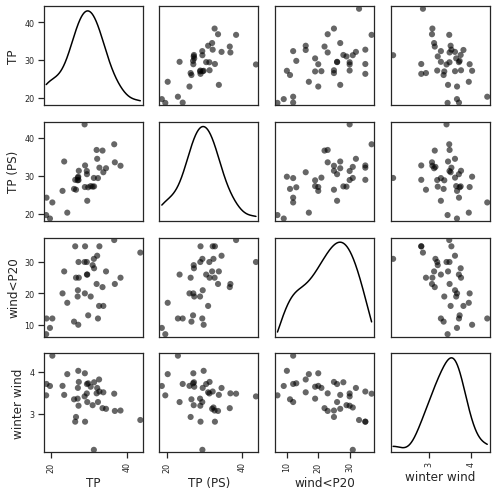

In [31]:
vars_for_scatterplot = [
    "TP_lake",
    "TP_lake_prevSummer",
    "Wind_under_Q0.2",
    "Wind_speed_lag1",
    # "Wind_speed",
    # "Q"
]
plot_scattermatrix(season_var_df, vars_for_scatterplot, 'TP')

## Response var = Lake chl-a concentration

In [17]:
# 2) chl-a concentration
cols_to_drop = [
#  'Biovolume',
 'CyanoBiovol',
 'CyanoBiovol_prevSummer',
 "PET",
 "PET_lag1",
#  'PTI',
 'Temp_subzero'
    ]

season_df_lake_chla = season_var_df.drop(cols_to_drop,axis=1)
print (len(season_df_lake_chla))

# Drop any rows where explanatory variable value is a NaN
season_df_lake_chla.dropna(subset=['chl-a_lake'], inplace=True)
print (len(season_df_lake_chla))
# monthly_df_lake_chla.head()

39
38


In [42]:
# sorted(season_df_lake_chla.columns)
len(season_df_lake_chla.columns) - 2

27

In [33]:
X = season_df_lake_chla.drop(['chl-a_lake'],axis=1)
y = season_df_lake_chla['chl-a_lake']
corr_df = X.corrwith(y, method='pearson')
print(corr_df.sort_values())
corr_df.sort_values().to_csv(os.path.join(corr_coeff_folder, 'corr_coeffs_chla_%s.csv' %met_source))
corr_df.sort_values()

Wind_over_Q0.6           -0.511171
Wind_speed               -0.509073
Wind_over_Q0.8           -0.488407
Wind_over_Q0.6_lag1      -0.292697
TP_catch                 -0.277073
Wind_over_Q0.8_lag1      -0.235561
Wind_speed_lag1          -0.224530
Q                        -0.118536
Rain_day                 -0.056026
Q_lag1                   -0.045299
Pptn                      0.004497
Pptn_intense_lag1         0.023696
colour_lake_prevSummer    0.056162
PET_lag1                  0.058593
Pptn_lag1                 0.061462
Pptn_intense              0.065821
Rain_day_lag1             0.069899
Temp_prevSummer           0.115109
Temp_lag1                 0.154622
colour_lake               0.156121
Wind_under_Q0.4_lag1      0.156643
Wind_under_Q0.2_lag1      0.162138
Temp                      0.219597
Wind_under_Q0.2           0.294241
TP_lake_prevSummer        0.314649
PET                       0.359687
Wind_under_Q0.4           0.411067
TP_lake                   0.577868
chl-a_lake_prevSumme

Wind_over_Q0.6           -0.511171
Wind_speed               -0.509073
Wind_over_Q0.8           -0.488407
Wind_over_Q0.6_lag1      -0.292697
TP_catch                 -0.277073
Wind_over_Q0.8_lag1      -0.235561
Wind_speed_lag1          -0.224530
Q                        -0.118536
Rain_day                 -0.056026
Q_lag1                   -0.045299
Pptn                      0.004497
Pptn_intense_lag1         0.023696
colour_lake_prevSummer    0.056162
PET_lag1                  0.058593
Pptn_lag1                 0.061462
Pptn_intense              0.065821
Rain_day_lag1             0.069899
Temp_prevSummer           0.115109
Temp_lag1                 0.154622
colour_lake               0.156121
Wind_under_Q0.4_lag1      0.156643
Wind_under_Q0.2_lag1      0.162138
Temp                      0.219597
Wind_under_Q0.2           0.294241
TP_lake_prevSummer        0.314649
PET                       0.359687
Wind_under_Q0.4           0.411067
TP_lake                   0.577868
chl-a_lake_prevSumme

**Comments on chl-a correlations for Van 2:**

- Mean chl-a the previous summer (0.65). i.e. stronger than when early and late summer were looked at separately (0.59, 0.53)
- TP-lake (0.58). Similar to late summer CC (0.59), and stronger than early summer alone
- Wind (met.no): e.g. over Q0.6 (-0.51), wind speed (-0.51), over Q0.8 (-0.49), under Q0.4 (0.41). Similar to 2 seasons, slightly weaker (early summer had up to -0.53, late summer up to -0.56)
- Wind (ERA5): not as strong CCs as with met.no data. Strongest is Wind_speed (-0.42) and Wind_under_Q0.2 (0.42). Scatterplot still looks reasonably convincing though, just lots of spread.
- PET (0.36), Temp (0.22). Both unconvincing on scatter plot. Temp_prevSummer looks a bit more convincing on scatterplot, though CC low (0.12).

**Temperature effect very weak when looking at one season at a time!! Wind and nutrients appear more important**

Spearman's rank:
- TP_lake (0.66)
- chl-a_lake_prevSummer (0.65)
- Wind_speed, met.no: wind over Q0.6 or 0.8 (-0.43)
- Wind_speed, ERA5: wind_under_Q0.2 (0.42), Wind_speed (-0.36)

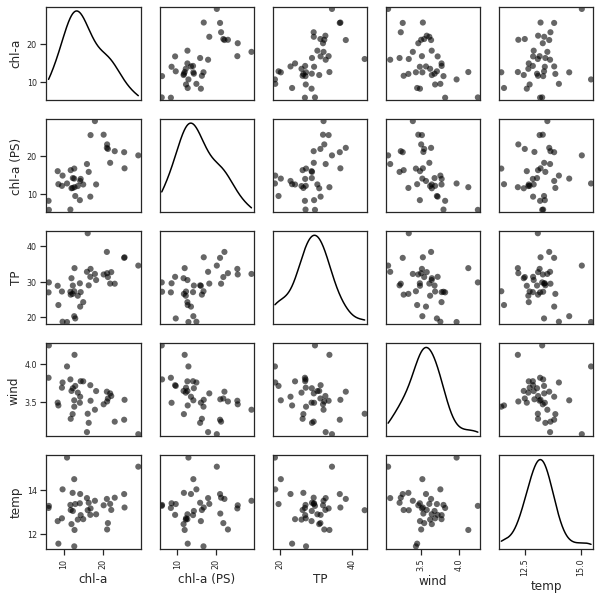

In [40]:
vars_for_scatterplot = ['chl-a_lake',
                        'chl-a_lake_prevSummer',
                        'TP_lake',
                        'Wind_speed',
                        # 'Wind_over_Q0.6',
                        'Temp']

plot_scattermatrix(season_var_df, vars_for_scatterplot, 'chl-a')

## Response var = max cyanobacterial biovolume

In [28]:
# cols to drop:
cols_to_drop = [
#  'Biovolume',
#  'PTI',
 "PET",
 "PET_lag1",
 'Temp_subzero'
    ]

season_df_cyano = season_var_df.drop(cols_to_drop,axis=1)
print (len(season_df_cyano))

# Drop any rows where explanatory var value is a NaN
season_df_cyano.dropna(subset=['CyanoBiovol'], inplace=True)
print (len(season_df_cyano))

39
23


In [31]:
# sorted(season_df_cyano.columns)
len(season_df_cyano.columns) - 2

29

In [36]:
X = season_df_cyano.drop(['CyanoBiovol'],axis=1)
y = season_df_cyano['CyanoBiovol']
corr_df = X.corrwith(y, method='pearson')
print(corr_df.sort_values())
corr_df.sort_values().to_csv(os.path.join(corr_coeff_folder, 'corr_coeffs_cyano_%s.csv' %met_source))

colour_lake_prevSummer   -0.497767
colour_lake              -0.440540
Wind_over_Q0.6_lag1      -0.383631
Wind_speed_lag1          -0.314211
Temp_prevSummer          -0.261873
Wind_over_Q0.6           -0.249123
Wind_over_Q0.8_lag1      -0.238124
Wind_speed               -0.202043
Pptn_intense_lag1        -0.200102
Temp                     -0.198354
PET                      -0.197774
Q_lag1                   -0.176347
PET_lag1                 -0.174398
Q                        -0.162922
Pptn_lag1                -0.111964
Temp_lag1                -0.090535
Wind_over_Q0.8           -0.084422
Rain_day                 -0.071290
Rain_day_lag1            -0.040312
Pptn                     -0.033442
Pptn_intense              0.128758
TP_catch                  0.166735
Wind_under_Q0.4           0.232004
Wind_under_Q0.4_lag1      0.268457
Wind_under_Q0.2           0.302548
Wind_under_Q0.2_lag1      0.354052
TP_lake_prevSummer        0.491975
CyanoBiovol_prevSummer    0.554195
chl-a_lake_prevSumme

**Cyanomax correlations in Van 2:**

- chl-a_lake (0.77). Same as when split into two seasons, CCs just as high
- TP_lake (0.58). Tiny bit smaller CC than late summer but not much (0.62), higher than early summer (0.42)
- Previous summer: chl-a (0.56), av cyano (0.55), TP (0.49). Similar to early summer, bit smaller CCs than late summer (0.67 for LS mean cyano)
- Lake colour: previous summer (-0.50), this summer (-0.44). More coloured means less cyano, which makes sense. But correlation vs causation? Don't see colour effect with chl-a. Would we expect cyano to be affected, and not chl-a? Have asked Sigrid Haande this in the past, but can't remember the answer. Think perhaps yes, because they use a different bit of the light spectrum. Similar to early & late summer CCs.
- Wind variables: not much. Wind_under_Q0.2 (0.30), and winter wind vars (>Q0.6 -0.38, mean speed -0.31). CCs of about 0.4 for early & late summer.
- Temp: negative correlations if anything! Current season (-0.2), previous summer -0.26

Spearman's rank:
- chl-a_lake (0.83)
- Previous summer cyano (0.71), chl-a (0.70), TP (0.63)
- Colour (previous summer: -0.47, this summer: -0.45)

/tmp/ipykernel_146/2381450108.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_var_df['cyano_bxcx'] = boxcox(season_var_df['CyanoBiovol'].values, lmbda=0.1)


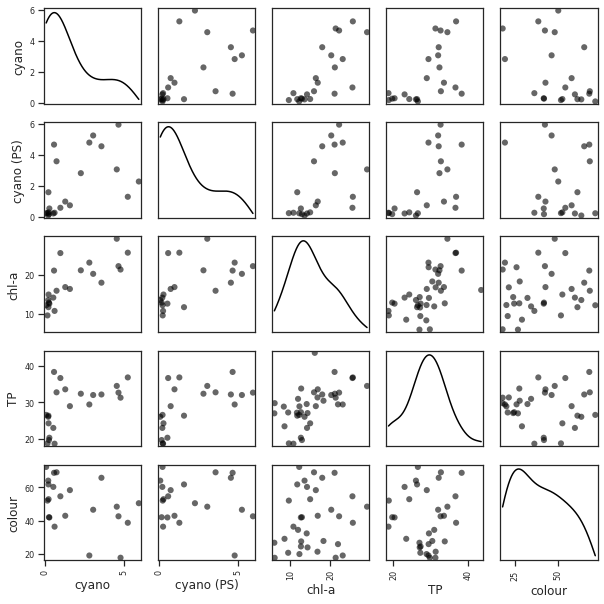

In [49]:
vars_for_scatterplot = ['CyanoBiovol',
                        'CyanoBiovol_prevSummer',
                        'chl-a_lake',
                        'TP_lake',
                        'colour_lake',
                        # 'Wind_under_Q0.2',
                       ]

plot_scattermatrix(season_var_df, vars_for_scatterplot, 'cyano')

/tmp/ipykernel_146/1334616567.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_var_df["cyano_bxcx"] = boxcox(season_var_df["CyanoBiovol"].values, lmbda=0.1)


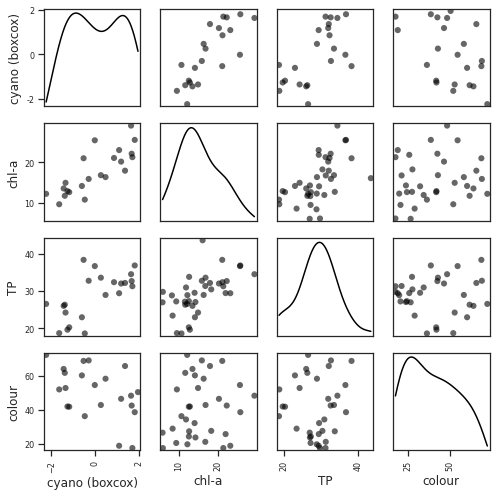

In [50]:
season_var_df["cyano_bxcx"] = boxcox(season_var_df["CyanoBiovol"].values, lmbda=0.1)

vars_for_scatterplot = ["cyano_bxcx", "chl-a_lake", "TP_lake", "colour_lake"]

plot_scattermatrix(season_var_df, vars_for_scatterplot, "cyano_bxcx")

## Response var = Lake colour

In [36]:
# Drop all ecological-related stuff

cols_to_drop = [
#  'Biovolume',
 'CyanoBiovol',
 'CyanoBiovol_prevSummer',
#  'PTI',
 'Season',
 'TP_catch',
 'TP_lake',
 'TP_lake_prevSummer',
 'chl-a_lake',
 'chl-a_lake_prevSummer',
 'Temp_subzero',
 "PET",
 "PET_lag1",
    ]

season_df_lakeColour = season_var_df.drop(cols_to_drop,axis=1)
print (len(season_df_lakeColour))

# Drop any rows where response var is a NaN
season_df_lakeColour.dropna(subset=['colour_lake'], inplace=True)
print (len(season_df_lakeColour))
season_df_lakeColour.head()

39
35


,Pptn,Temp,Wind_speed,Q,colour_lake,Rain_day,Pptn_intense,Wind_under_Q0.2,Wind_under_Q0.4,Wind_over_Q0.6,...,Wind_speed_lag1,Q_lag1,Rain_day_lag1,Pptn_intense_lag1,Wind_under_Q0.2_lag1,Wind_under_Q0.4_lag1,Wind_over_Q0.6_lag1,Wind_over_Q0.8_lag1,colour_lake_prevSummer,Temp_prevSummer
Date,,,,,,,,,,,,,,,,,,,,,
1982-10-31,458.474789,13.190846,3.818478,39.515126,26.666667,64.0,18.0,19.0,52.0,82.0,...,3.360221,96.428880,60.0,10.0,47.0,82.0,69.0,41.0,NaN,12.599971
1983-10-31,466.631052,13.283700,4.247283,47.977834,17.625000,63.0,14.0,13.0,49.0,94.0,...,3.728177,124.071782,68.0,14.0,44.0,72.0,77.0,48.0,26.666667,13.190846
1985-10-31,548.374613,12.465199,3.644022,95.430528,34.404762,75.0,18.0,29.0,72.0,72.0,...,3.203315,106.745818,62.0,12.0,50.0,83.0,63.0,32.0,NaN,13.326957
1986-10-31,429.271284,12.202530,4.122283,NaN,27.472222,64.0,13.0,16.0,47.0,95.0,...,3.512155,27.737338,53.0,10.0,53.0,78.0,70.0,46.0,34.404762,12.465199
1987-10-31,708.329005,11.587689,3.451630,NaN,29.027778,85.0,21.0,27.0,69.0,62.0,...,3.450276,NaN,60.0,9.0,49.0,82.0,67.0,43.0,27.472222,12.202530


In [40]:
# sorted(season_df_lakeColour.columns)
len(season_df_lakeColour.columns) - 1

22

In [39]:
X = season_df_lakeColour.drop(['colour_lake'],axis=1)
y = season_df_lakeColour['colour_lake']
corr_df = X.corrwith(y, method='pearson')
print(corr_df.sort_values())
corr_df.sort_values().to_csv(os.path.join(corr_coeff_folder, 'corr_coeffs_colour_%s.csv' %met_source))

Wind_over_Q0.8           -0.469205
Wind_speed               -0.458943
Wind_over_Q0.6           -0.446843
Wind_over_Q0.6_lag1      -0.266339
Wind_over_Q0.8_lag1      -0.255410
Wind_under_Q0.2_lag1     -0.167840
Wind_speed_lag1          -0.152769
TP_lake                   0.036209
TP_catch                  0.050772
Rain_day_lag1             0.137185
Wind_under_Q0.4_lag1      0.141319
Wind_under_Q0.2           0.151229
Temp_lag1                 0.165608
Pptn_lag1                 0.223417
Pptn_intense_lag1         0.259167
PET_lag1                  0.278394
Wind_under_Q0.4           0.297364
Q_lag1                    0.321284
Temp                      0.350542
Rain_day                  0.383785
PET                       0.392616
Temp_prevSummer           0.427524
Q                         0.445643
Pptn_intense              0.459151
Pptn                      0.526432
colour_lake_prevSummer    0.854938
dtype: float64


**Lake colour correlations in Van 2, comments:**

**Summer:**
- Strong auto-correlation with lake colour the previous summer (0.85) (Spearman's: 0.85)
- Delivery, met.no: Pptn (0.53)(Spearman's: 0.56), intense pptn (0.46), Q (0.45). ERA5, slightly weaker ccs (rain_day highest, 0.47; Pptn 0.47)
- Wind: over Q0.8 (-0.47), wind (-0.49) (Spearman's: wind speed best, -0.43)
- Temp prev summer (0.43) (current summer: 0.35)

i.e. could put this back into the network, to have a precipitation link...?

**Winter:**
Only 22 data points.
Strongest correlations, to include
- Previous season's precipitation and discharge (0.58, 0.57)
- Previous summer colour (0.56)

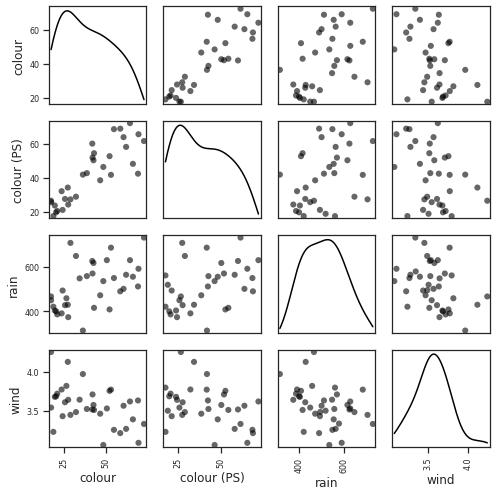

In [55]:
vars_for_scatterplot = [
    "colour_lake",
    "colour_lake_prevSummer",
    "Pptn",
    "Wind_speed"
    # 'Pptn_intense',
]  # Summer
# vars_for_scatterplot = ['colour_lake', 'Pptn_lag1', 'Q_lag1','colour_lake_prevSummer']  # winter

plot_scattermatrix(season_var_df, vars_for_scatterplot, "colour")

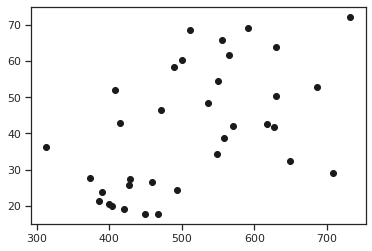

In [41]:
# This plot looks more convincing with met.no precipitation data than it does with ERA5 data
plt.plot(season_var_df['Pptn'],season_var_df['colour_lake'],'ko')

## Write output csvs split by variable

In [42]:
# season_df_TP.to_csv(os.path.join(out_file,'dataMatrix_seasonal_TP_%s_%s.csv'%(season_slice,basin)), index_label='Date')
# season_df_lake_chla.to_csv(os.path.join(out_file,'dataMatrix_seasonal_Chl-a_%s_%s.csv'%(season_slice,basin)), index_label='Date')
# season_df_cyano.to_csv(os.path.join(out_file,'dataMatrix_seasonal_CyanoBiovol_%s_%s.csv'%(season_slice,basin)), index_label='Date')
# season_df_lakeColour.to_csv(os.path.join(out_file,'dataMatrix_seasonal_colour_lake_%s_%s.csv'%(season_slice,basin)), index_label='Date')